In [1]:
from collections import Counter
import os
import re

from matplotlib import font_manager, rc
from imutils.paths import list_files
import matplotlib.pyplot as plt
import geopandas as gpd
import requests as req
import pandas as pd
import numpy as np

In [2]:
ROOT_PATH = '/'.join(os.getcwd().split('/')[:-2])
DATA_PATH = f'{ROOT_PATH}/doodle/data/geo'
FONT_PATH = f'{ROOT_PATH}/doodle/data/fonts/NanumMyeongjo.ttf'

In [3]:
font = font_manager.FontProperties(fname = FONT_PATH).get_name()
rc('font', family = font)

In [4]:
def read_shp(path, sector = 'dong'): 
    
    if   sector ==   'dong': name_col = 'EMD_NM'
    elif sector ==  'towns': name_col = 'RI_NM'
    elif sector == 'cities': name_col = 'SGG_NM'
    
    return gpd.read_file(path, encoding = 'euc-kr')[name_col]

def clear_str(string):
    
    string = re.compile('[0-9*]가').sub('', string)
    string = re.compile('[^가-힣*]').sub('', string)[:-1]
    string = string.replace('특별자치', '')
    return ''.join(string.split('시'))

def all_sectors(files, sector = 'dong'):
    
    sectors     = ''
    num_sectors = {}
    
    for file in files:
        
        province = file.split(os.path.sep)[-2]
        sec      = read_shp(file, sector = sector).dropna()
        sec      = set([clear_str(s) for s in sec])
        sectors += ''.join(sec) 
        
        num_sectors[province] = len(sec)
    
    return sectors, num_sectors


def make_dirs(files, sector = 'dong'):
    
    dir_names = set([file.split('/')[-2] for file in files])
    [os.makedirs(f'{DATA_PATH}/{sector}/{dir_name}', exist_ok = True) 
     for dir_name in dir_names]
    

def ratio_calculator(string, all_cnt):
    
    string_cnt = Counter(string)
    top_20p    = string_cnt.most_common(len(all_cnt) // 5)
    
    sum_top20p = sum([top[1] for top in top_20p])
    sum_allcnt = sum([all for all in all_cnt.values()])
    
    return  sum_top20p / sum_allcnt, sum_top20p, sum_allcnt 

In [5]:
files            = [path for path in list_files(f'{DATA_PATH}/dongs') if path.split('.')[-1] == 'shp']
dongs, num_dongs = all_sectors(files)
dong_cnt         = sorted(Counter(dongs).items(), key = lambda x: x[1], reverse = True)
dong_cnt         = dict(dong_cnt)
num_dongs

{'DJ': 171,
 'BS': 133,
 'CB': 231,
 'CN': 272,
 'DG': 176,
 'JB': 347,
 'IC': 131,
 'JJ': 73,
 'JN': 376,
 'KB': 500,
 'KG': 670,
 'KN': 474,
 'KJ': 185,
 'KW': 269,
 'SJ': 33,
 'SU': 357,
 'US': 84}

In [6]:
Counter(dongs).most_common(20)

[('산', 326),
 ('신', 183),
 ('성', 178),
 ('남', 176),
 ('천', 171),
 ('대', 170),
 ('동', 167),
 ('곡', 158),
 ('정', 156),
 ('서', 134),
 ('도', 129),
 ('장', 122),
 ('화', 118),
 ('평', 115),
 ('수', 114),
 ('양', 110),
 ('암', 107),
 ('상', 105),
 ('용', 101),
 ('사', 99)]

In [7]:
ratio, sum_dong20p, sum_dongall = ratio_calculator(dongs, dong_cnt)
f'{ratio * 100:.3f} %'

'71.887 %'

<BarContainer object of 361 artists>

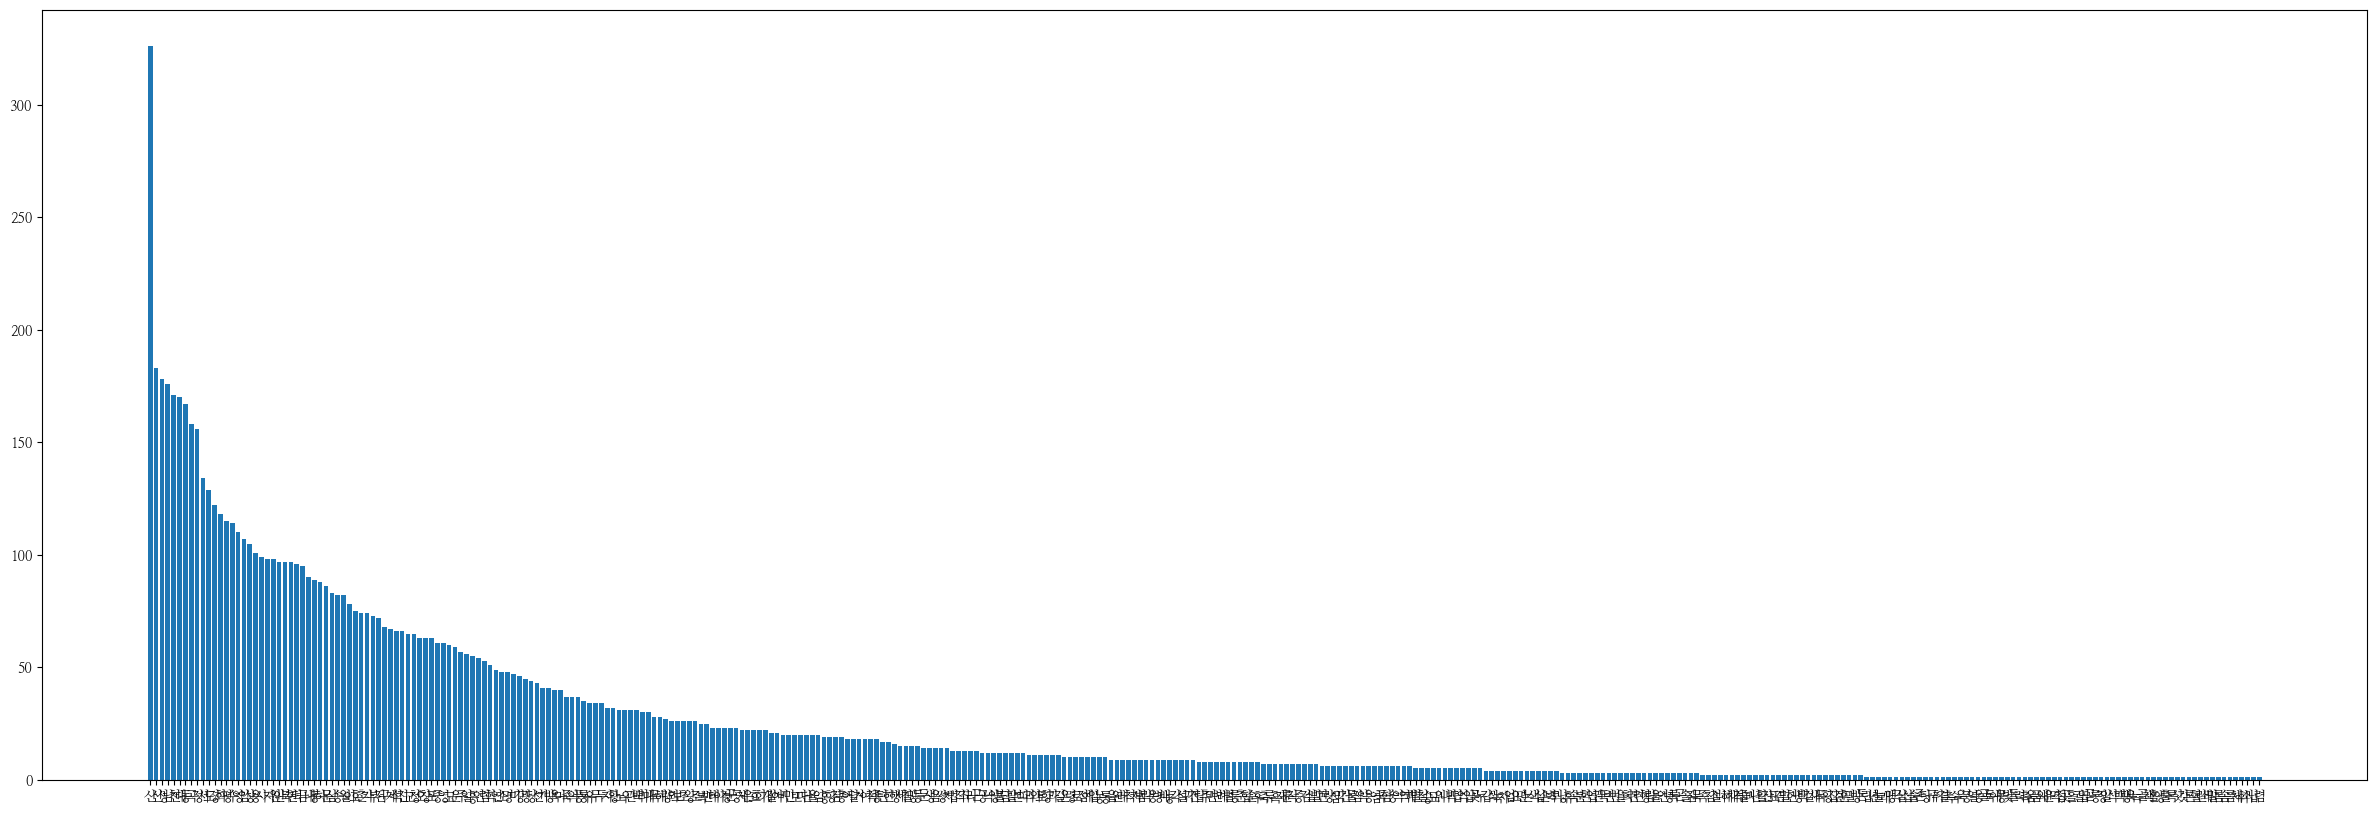

In [8]:
plt.figure(figsize = (30, 10))
plt.bar(dong_cnt.keys(), dong_cnt.values())

In [9]:
sum_dong20p, sum_dongall, 0.8 * sum_dongall

(6385, 8882, 7105.6)

In [10]:
make_dirs(files, sector = 'dongs')
make_dirs(files, sector = 'cities')
make_dirs(files, sector = 'towns')

In [11]:
files              = [path for path in list_files(f'{DATA_PATH}/cities') if path.split('.')[-1] == 'shp']
cities, num_cities = all_sectors(files, sector = 'cities')

not_uniques = [
               '천안', '청주', '안양', '고양', 
               '성남', '용인', '수원', '성남', 
               '안산', '창원'
              ]
for not_unique in not_uniques: 
    cities = cities.replace(not_unique, '') + not_unique
    
cities_cnt = sorted(Counter(cities).items(), 
                    key = lambda x: x[1], reverse = True)
cities_cnt = dict(cities_cnt)
num_cities

{'CN': 16,
 'CB': 15,
 'BS': 16,
 'DG': 8,
 'KB': 24,
 'KW': 18,
 'SJ': 1,
 'JB': 15,
 'IC': 10,
 'JJ': 2,
 'KN': 22,
 'US': 5,
 'DJ': 5,
 'JN': 22,
 'KJ': 5,
 'KG': 42,
 'SU': 25}

In [12]:
Counter(cities).most_common(10)

[('산', 22),
 ('주', 21),
 ('천', 21),
 ('양', 20),
 ('동', 20),
 ('성', 19),
 ('서', 16),
 ('남', 14),
 ('안', 14),
 ('영', 13)]

In [13]:
ratio, sum_cities20p, sum_citiesall = ratio_calculator(cities, cities_cnt)
f'{ratio * 100:.3f} %'

'60.271 %'

<BarContainer object of 141 artists>

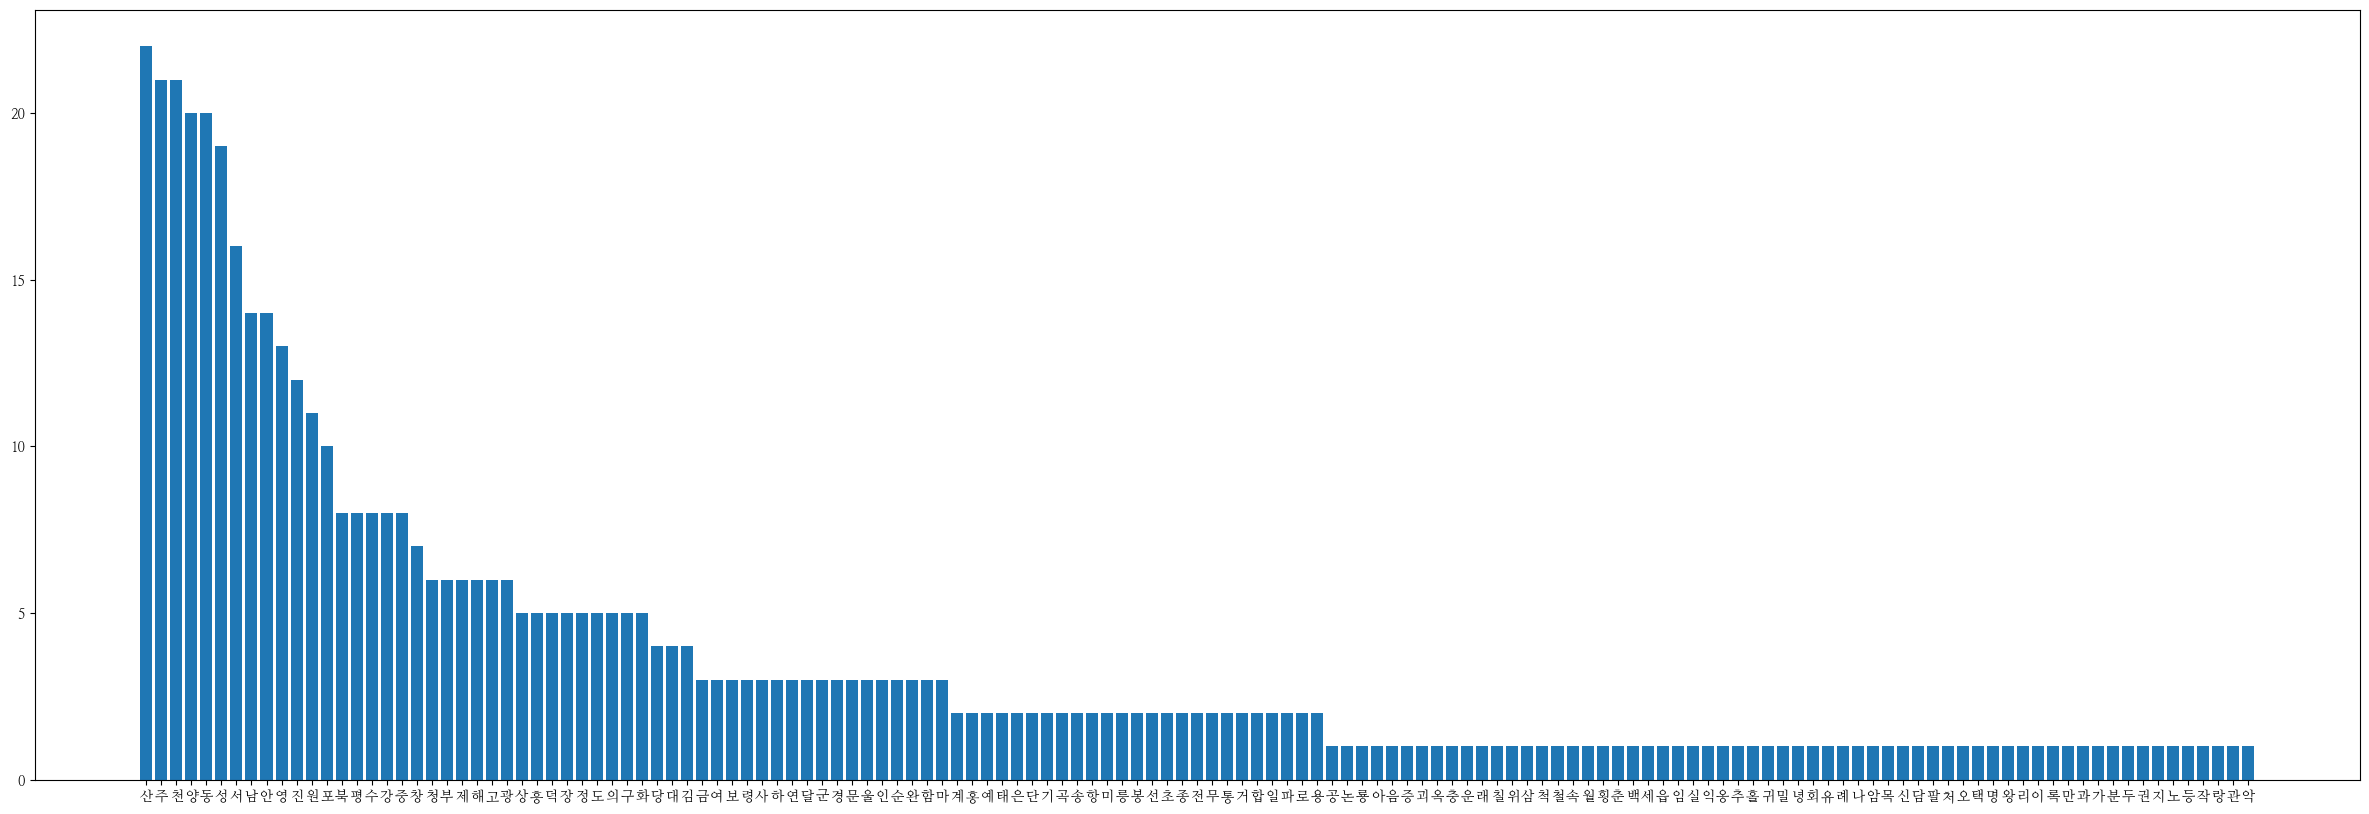

In [14]:
plt.figure(figsize = (30, 10))
plt.bar(cities_cnt.keys(), cities_cnt.values())

In [15]:
sum_cities20p, sum_citiesall, 0.8 * sum_citiesall

(311, 516, 412.8)

In [16]:
files            = [path for path in list_files(f'{DATA_PATH}/towns') if path.split('.')[-1] == 'shp']
towns, num_towns = all_sectors(files, sector = 'towns')
town_cnt         = sorted(Counter(towns).items(), key = lambda x: x[1], reverse = True)
town_cnt         = dict(town_cnt)
num_towns

{'SJ': 112,
 'CB': 1157,
 'JB': 1155,
 'IC': 121,
 'JJ': 117,
 'JN': 1765,
 'DG': 90,
 'KB': 2025,
 'KN': 1404,
 'KG': 1204,
 'SU': 19,
 'US': 114,
 'KW': 999,
 'BS': 62,
 'CN': 1524}

In [17]:
Counter(towns).most_common(20)

[('산', 717),
 ('곡', 578),
 ('동', 500),
 ('천', 485),
 ('대', 473),
 ('신', 447),
 ('정', 441),
 ('성', 367),
 ('상', 354),
 ('평', 343),
 ('도', 331),
 ('암', 330),
 ('장', 311),
 ('사', 310),
 ('수', 305),
 ('덕', 301),
 ('봉', 287),
 ('지', 285),
 ('전', 284),
 ('화', 283)]

In [18]:
ratio, sum_town20p, sum_townall = ratio_calculator(towns, town_cnt)
f'{ratio * 100:.3f} %'

'73.254 %'

<BarContainer object of 383 artists>

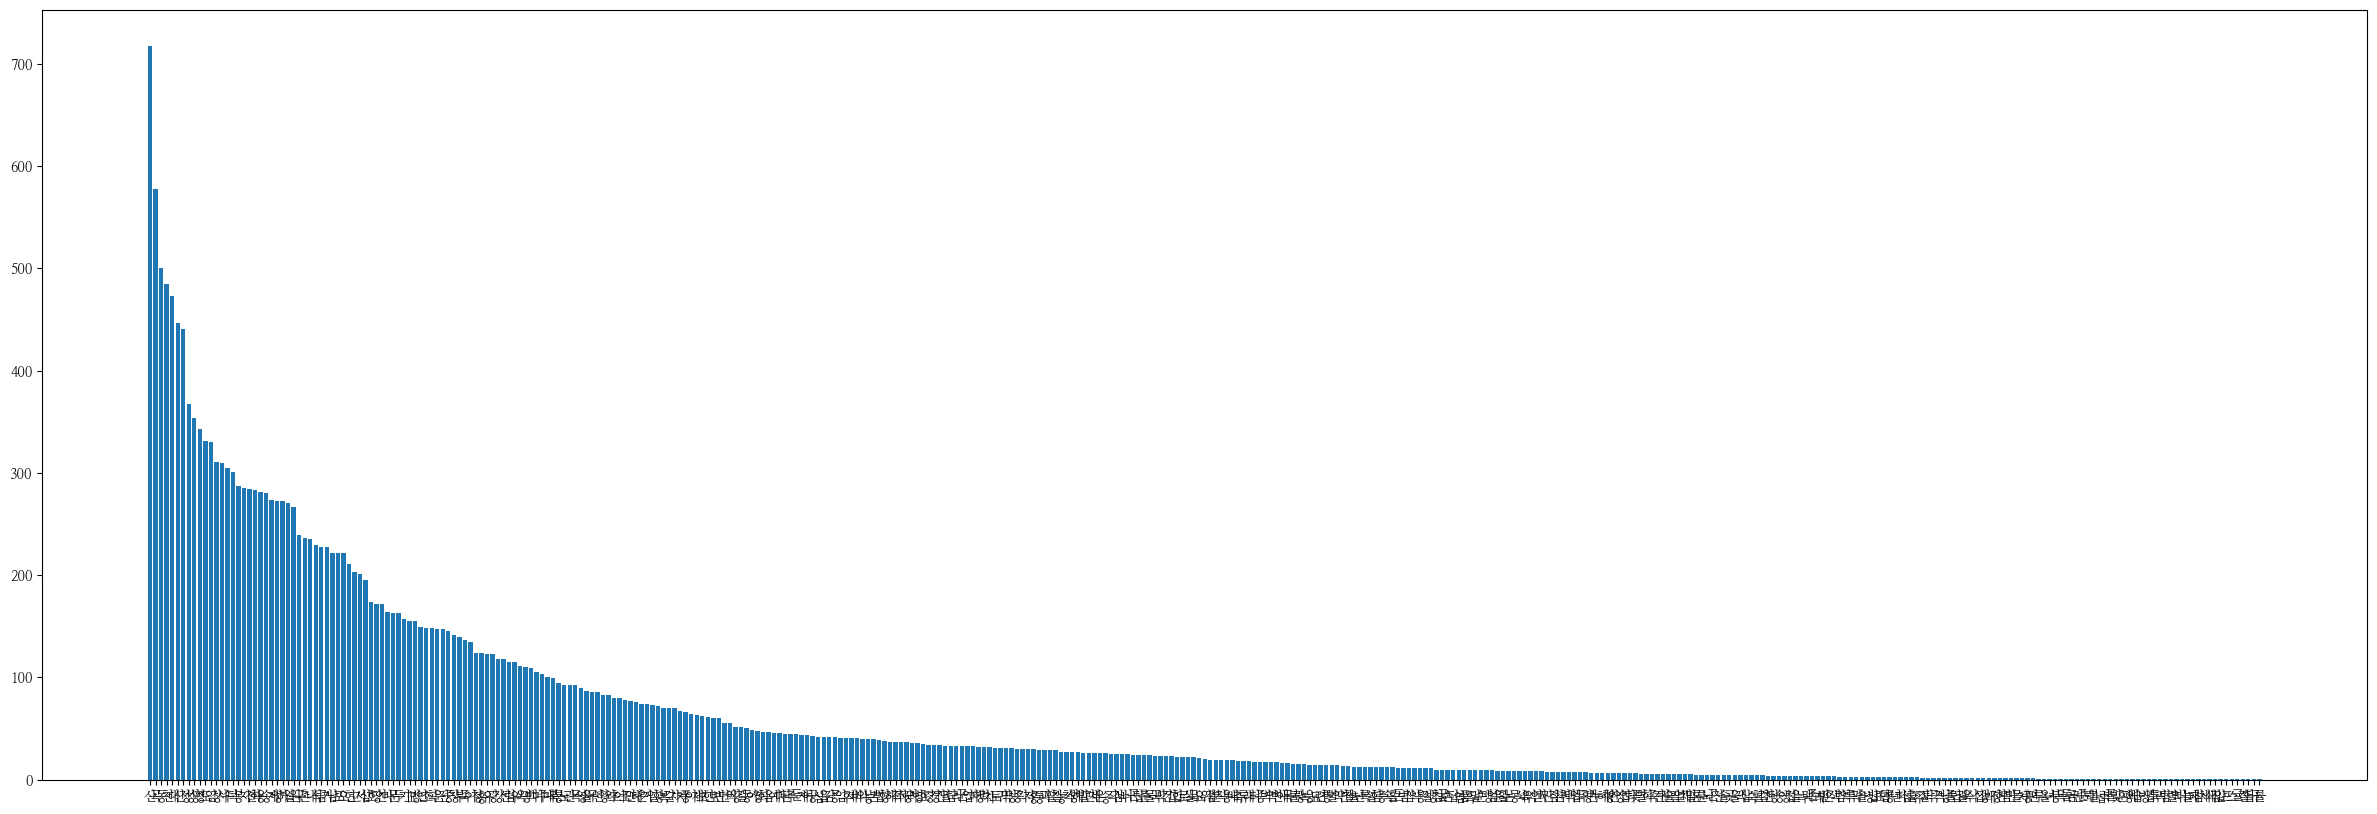

In [19]:
plt.figure(figsize = (30, 10))
plt.bar(town_cnt.keys(), town_cnt.values())

In [20]:
sum_town20p, sum_townall, 0.8 * sum_dongall

(17321, 23645, 7105.6)

In [21]:
region     = dongs + cities + towns
region_cnt = sorted(Counter(region).items(), key = lambda x: x[1], reverse = True)
region_cnt = dict(region_cnt)

In [22]:
Counter(region).most_common(20)

[('산', 1065),
 ('곡', 738),
 ('동', 687),
 ('천', 677),
 ('대', 647),
 ('신', 631),
 ('정', 602),
 ('성', 564),
 ('평', 466),
 ('도', 465),
 ('상', 464),
 ('장', 438),
 ('암', 438),
 ('수', 427),
 ('사', 412),
 ('남', 412),
 ('화', 406),
 ('양', 403),
 ('덕', 402),
 ('지', 384)]

In [23]:
ratio, sum_region20p, sum_regionall = ratio_calculator(region, region_cnt)
f'{ratio * 100:.3f} %'

'74.736 %'

<BarContainer object of 401 artists>

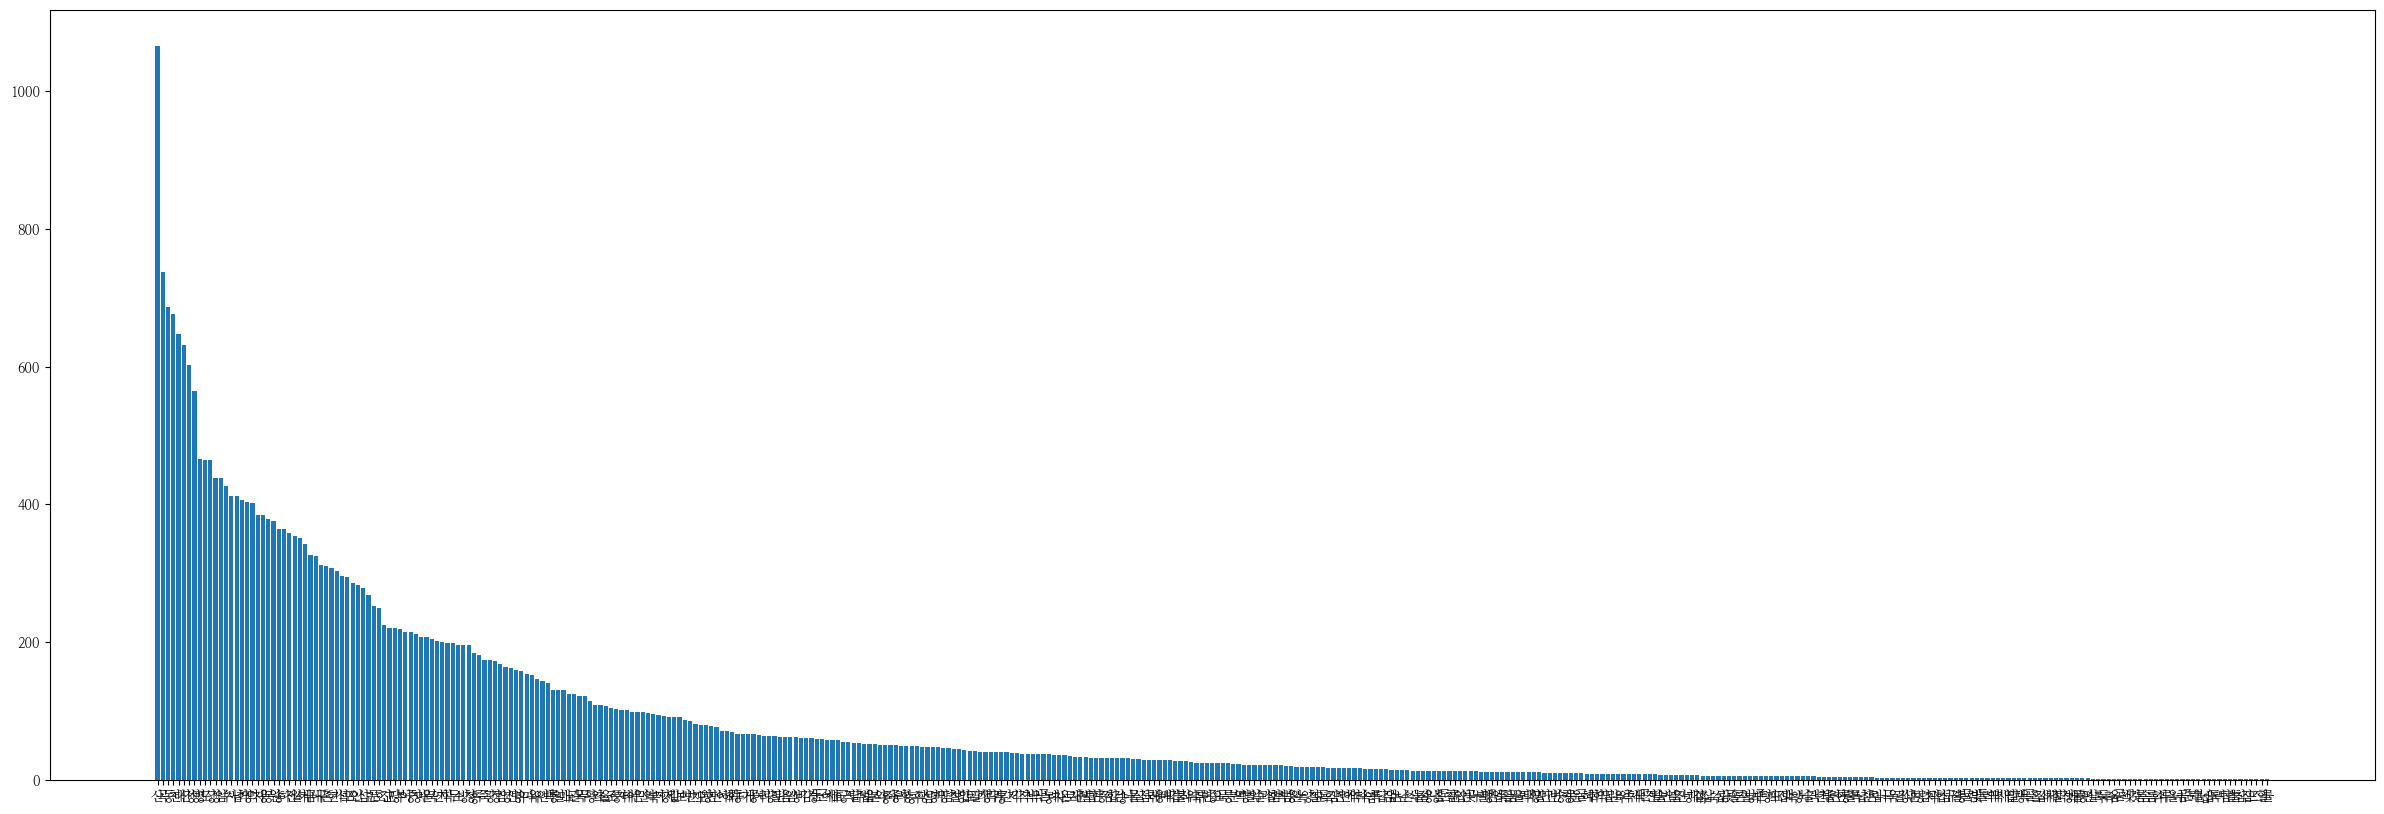

In [24]:
plt.figure(figsize = (30, 10))
plt.bar(region_cnt.keys(), region_cnt.values())

In [25]:
sum_region20p, sum_regionall, 0.8 * sum_regionall

(24695, 33043, 26434.4)